In [1]:
!pip install cmake
!pip install opencv-python
!conda install -y dlib

Channels:
 - conda-forge
Platform: linux-64
Solving environment: done

# All requested packages already installed.



In [2]:
# 필요한 패키지 import 하기
import os 
import cv2 #
import matplotlib.pyplot as plt 
import numpy as np 
import dlib 


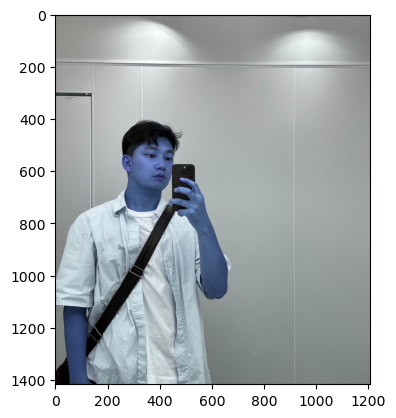

In [3]:
home_dir = os.getenv('HOME')
my_image_path = os.path.join(home_dir, 'work/camera_sticker/models/selfie2.jpg') # 본인 이미지가 있는 경로를 가지고 온다.
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옵니다
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관합니다
plt.imshow(img_bgr) # 이미지를 출력하기 위해 출력할 이미지를 올려준다. (실제 출력은 하지 않음)
plt.show() # 이미지를 출력해준다. (실제 출력)

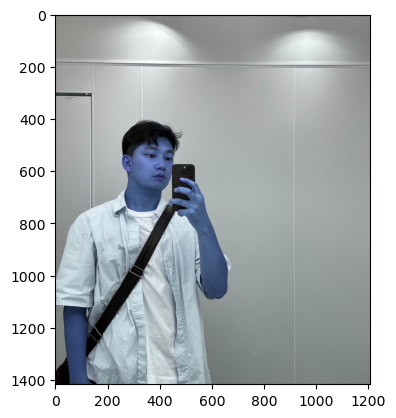

In [4]:
#RGB 변환
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_bgr)
plt.show() 

In [5]:
# detector선언
detector_hog = dlib.get_frontal_face_detector() 

In [6]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   

rectangles[[(304, 490) (489, 676)]]


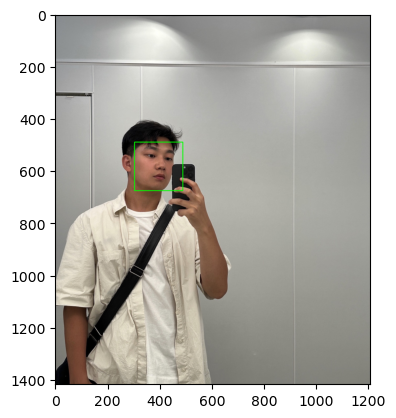

In [7]:
# 찾은 얼굴 영역 박스 리스트
print(dlib_rects)

for dlib_rect in dlib_rects: # 찾은 얼굴 영역의 좌표
    l = dlib_rect.left() # 왼쪽
    t = dlib_rect.top() # 위쪽
    r = dlib_rect.right() # 오른쪽
    b = dlib_rect.bottom() # 아래쪽

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA) # 시작점의 좌표와 종료점 좌표로 직각 사각형을 그림

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [8]:
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
!mv shape_predictor_68_face_landmarks.dat.bz2 ~/work/camera_sticker/models
!cd ~/work/camera_sticker && bzip2 -d ./models/shape_predictor_68_face_landmarks.dat.bz2

--2025-07-28 08:00:34--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2 [following]
--2025-07-28 08:00:34--  https://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Connecting to dlib.net (dlib.net)|107.180.26.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  17.1MB/s    in 4.3s    

2025-07-28 08:00:39 (14.3 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]

bzip2: Output file ./models/shape_predictor_68_face_landmarks.dat already exists.


In [9]:
model_path = os.path.join(home_dir, 'work/camera_sticker/models/shape_predictor_68_face_landmarks.dat')
    # 저장한 landmark 모델의 주소를 model_path 변수에 저장
landmark_predictor = dlib.shape_predictor(model_path)

In [10]:
list_landmarks = []

for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))
 

68


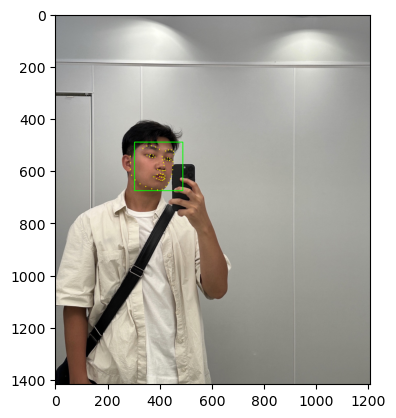

In [11]:
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [12]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks): 
    print (landmark[33]) 
    x = landmark[33][0] 
    y = landmark[33][1] - dlib_rect.height()//2 
    w = h = dlib_rect.width()
    print (f'(x,y) : ({x},{y})')
    print (f'(w,h) : ({w},{h})')

(410, 599)
(x,y) : (410,506)
(w,h) : (186,186)


In [13]:
sticker_path = os.path.join(home_dir, 'work/camera_sticker/images/cat-whiskers.png') # 왕관 이미지의 경로
img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다 // cv2.imread(이미지 경로) → image객체 행렬을 반환
img_sticker = cv2.resize(img_sticker, (w,h)) # 스티커 이미지 조정 → w,h는 얼굴 영역의 가로를 차지하는 픽셀의 수(187) // cv2.resize(image객체 행렬, (가로 길이, 세로 길이))
print (img_sticker.shape) # 사이즈를 조정한 왕관 이미지의 차원 확인

(186, 186, 3)


In [14]:
# 4. 얼굴 랜드마크 추출
if len(dlib_rects) > 0:
    landmarks = [landmark_predictor(img_rgb, rect) for rect in dlib_rects]

    # 5. 코 좌표 추출
    nose_x = landmarks[0].part(30).x
    nose_y = landmarks[0].part(30).y

    # 6. 스티커 위치 계산
    refined_x = nose_x - img_sticker.shape[1] // 2
    refined_y = nose_y - img_sticker.shape[0] // 2

if refined_x < 0:
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0

if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :] 
    refined_y = 0

print (f'(x,y) : ({refined_x},{refined_y})')

refined_x = max(0, min(refined_x, img_rgb.shape[1] - img_sticker.shape[1]))
refined_y = max(0, min(refined_y, img_rgb.shape[0] - img_sticker.shape[0]))

# 8. 스티커 합성
sticker_area = img_rgb[refined_y:refined_y + img_sticker.shape[0],
                       refined_x:refined_x + img_sticker.shape[1]]

img_rgb[refined_y:refined_y + img_sticker.shape[0],
        refined_x:refined_x + img_sticker.shape[1]] = \
        np.where(img_sticker == 0, sticker_area, img_sticker).astype(np.uint8)

(x,y) : (324,487)


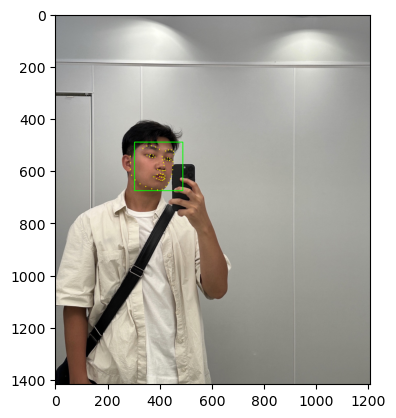

In [15]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

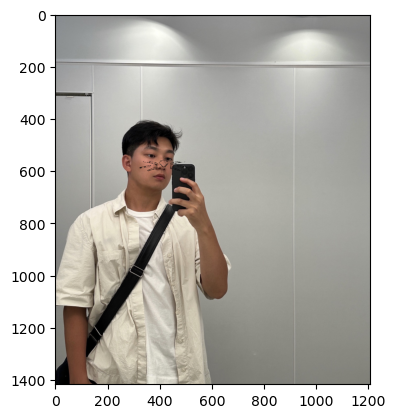

In [16]:

sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)) # rgb만 적용해놓은 원본 이미지에 왕관 이미지를 덮어 씌운 이미지가 나오게 된다.
plt.show()